In [1]:

import logging
import os
import warnings

import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers
from tensorflow.keras.models import Model
#../usr/lib/utils/utils.py
from utils.utils import *

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
defo_types = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")
defo_types.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
label_freq = defo_types['tags'].apply(lambda x: str(x).split(' ')).explode().value_counts().sort_values(ascending=False)

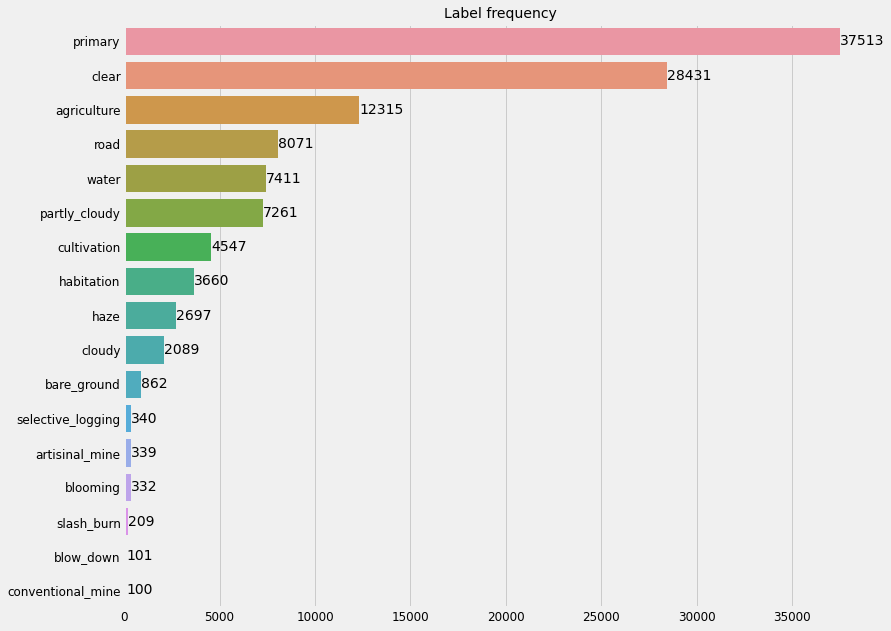

In [4]:
# Bar plot
style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(ax=ax, y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
rare = list(label_freq[label_freq<1000].index)
print(rare)


['bare_ground', 'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down', 'conventional_mine']


In [6]:
rep_dict = {'partly_cloudy': 'cloudy', 'haze':'cloudy'}
def lbl_reorg(x):
    res = []
    for i in str(x).split(" "):
        if i not in rare:
            if i not in rep_dict.keys():
                res.append(i)
            else:
                res.append(rep_dict[i])
    return res

In [7]:
defo_types['classes'] = defo_types['tags'].apply(lambda x:lbl_reorg(x))
defo_types.head()

,image_name,tags,classes
0,train_0,haze primary,"[cloudy, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"


In [8]:
X_train, X_val, y_train, y_val = train_test_split(defo_types['image_name'], defo_types['classes'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  32383
Number of posters for validation:  8096


In [9]:
root = '../input/planets-dataset/planet/planet/train-jpg'
X_train = [os.path.join(root, str(f)+'.jpg') for f in X_train]
X_val = [os.path.join(root, str(f)+'.jpg') for f in X_val]
X_train[:3]

['../input/planets-dataset/planet/planet/train-jpg/train_32580.jpg',
 '../input/planets-dataset/planet/planet/train-jpg/train_541.jpg',
 '../input/planets-dataset/planet/planet/train-jpg/train_11932.jpg']

In [10]:
y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['clear', 'primary'],
 ['agriculture', 'cultivation', 'cloudy', 'primary', 'water'],
 ['cloudy', 'primary']]

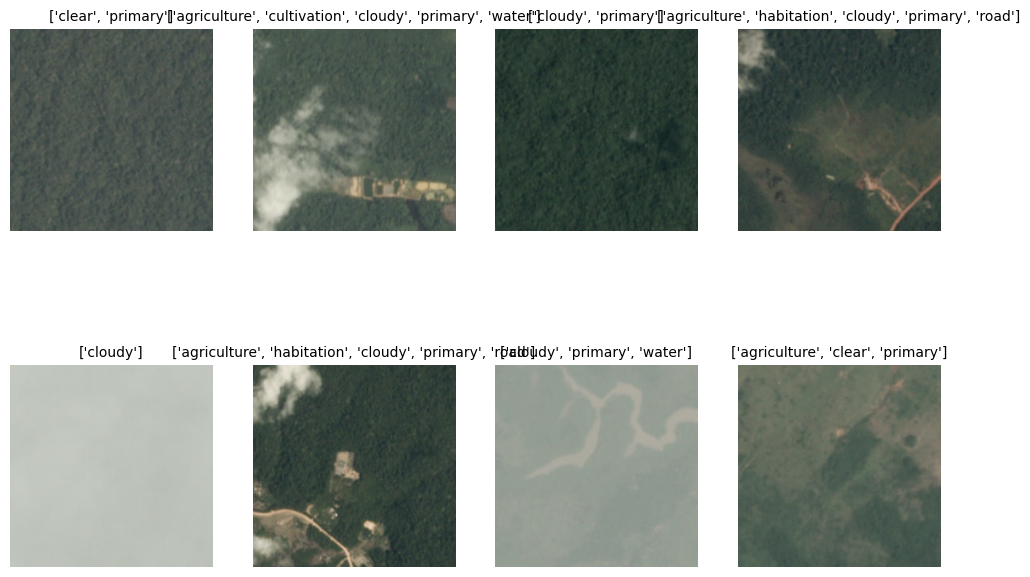

In [11]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(X_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

In [12]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. agriculture
1. clear
2. cloudy
3. cultivation
4. habitation
5. primary
6. road
7. water


In [13]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [14]:
# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])

../input/planets-dataset/planet/planet/train-jpg/train_32580.jpg [0 1 0 0 0 1 0 0]
../input/planets-dataset/planet/planet/train-jpg/train_541.jpg [1 0 1 1 0 1 0 1]
../input/planets-dataset/planet/planet/train-jpg/train_11932.jpg [0 0 1 0 0 1 0 0]


In [15]:
IMG_SIZE = 224
CHANNELS = 3 
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [16]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE 
SHUFFLE_BUFFER_SIZE = 1000
N_LABELS = 8

In [17]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [18]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [19]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (128, 224, 224, 3)
Shape of labels array: (128, 8)


In [20]:
# feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
# feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
#                                          input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
feat_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

29089792/29084464 [==============================] - 0s 0us/step


In [21]:
def create_model(img_size,channels):
    feat_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size,img_size,channels))
    
    for layer in feat_model.layers:
        layer.trainable = False
        
    x = feat_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu', name='last_linear')(x)
    x = layers.Dense(N_LABELS, activation='sigmoid', name='output')(x)
    model = Model(inputs=feat_model.input, outputs=x, name='multi_class_multi_label_classifier')
    return model
# feature_extractor_layer.trainable = False
# model = tf.keras.Sequential([
#     feature_extractor_layer,
#     layers.Dense(1024, activation='relu', name='hidden_layer'),
#     layers.Dense(N_LABELS, activation='sigmoid', name='output')
# ])

# model.summary()
model = create_model(IMG_SIZE,CHANNELS)

In [ ]:
model.summary()

In [22]:
for batch in train_ds:
#     print(batch[0].shape)
    print(model.predict(batch[0])[:1])
    break

[[0.7171016  0.5059814  0.62921184 0.5344676  0.53785473 0.6584627
  0.4974552  0.48249277]]


In [23]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [24]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [25]:
LR = 1e-5 
EPOCHS = 5
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [26]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/5
253/253 [==============================] - 174s 654ms/step - loss: 0.5910 - macro_f1: 0.4519 - val_loss: 0.5540 - val_macro_f1: 0.4640
Epoch 2/5
253/253 [==============================] - 92s 356ms/step - loss: 0.5512 - macro_f1: 0.4632 - val_loss: 0.5433 - val_macro_f1: 0.4650
Epoch 3/5
253/253 [==============================] - 88s 341ms/step - loss: 0.5431 - macro_f1: 0.4633 - val_loss: 0.5401 - val_macro_f1: 0.4645
Epoch 4/5
253/253 [==============================] - 85s 332ms/step - loss: 0.5403 - macro_f1: 0.4632 - val_loss: 0.5381 - val_macro_f1: 0.4643
Epoch 5/5
253/253 [==============================] - 86s 335ms/step - loss: 0.5392 - macro_f1: 0.4629 - val_loss: 0.5375 - val_macro_f1: 0.4642

Training took 0h:8m:44s


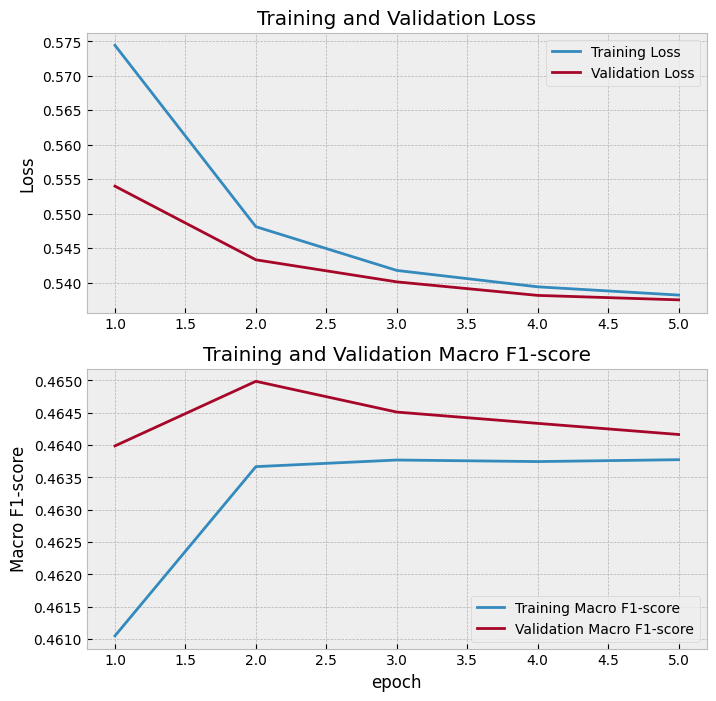

In [27]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

In [28]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.54
Macro F1-score: 0.46


In [29]:
model_bce = create_model(IMG_SIZE,CHANNELS)

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train_ds,
                            epochs=EPOCHS,
                            validation_data=create_dataset(X_val, y_val_bin))
print('\nTraining took {}'.format(print_time(time()-start)))

Epoch 1/5
253/253 [==============================] - 90s 328ms/step - loss: 0.4809 - macro_f1: 0.2206 - val_loss: 0.4686 - val_macro_f1: 0.2228
Epoch 2/5
253/253 [==============================] - 83s 322ms/step - loss: 0.4675 - macro_f1: 0.2229 - val_loss: 0.4674 - val_macro_f1: 0.2228
Epoch 3/5
253/253 [==============================] - 82s 320ms/step - loss: 0.4672 - macro_f1: 0.2230 - val_loss: 0.4689 - val_macro_f1: 0.2229
Epoch 4/5
253/253 [==============================] - 83s 322ms/step - loss: 0.4668 - macro_f1: 0.2230 - val_loss: 0.4687 - val_macro_f1: 0.2227
Epoch 5/5
253/253 [==============================] - 83s 322ms/step - loss: 0.4663 - macro_f1: 0.2230 - val_loss: 0.4698 - val_macro_f1: 0.2228

Training took 0h:7m:1s


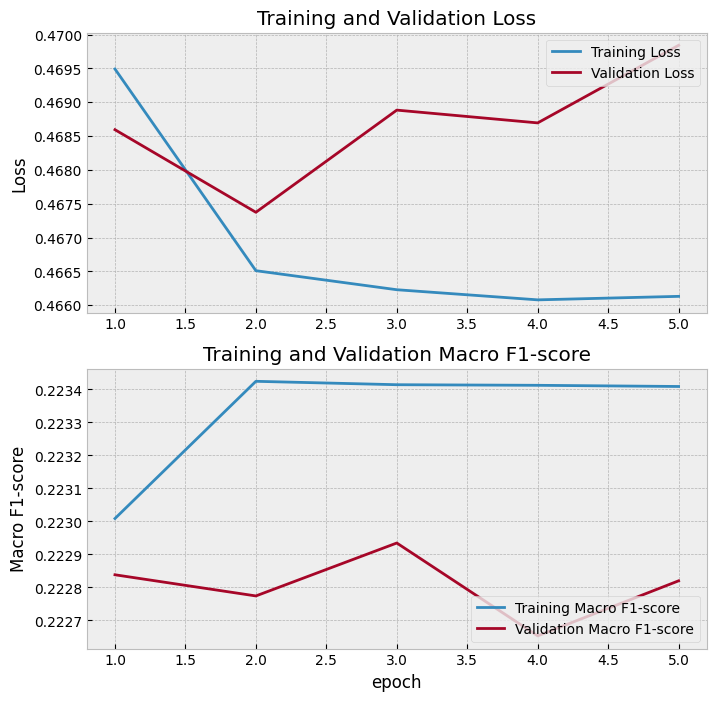

In [30]:
model_bce_losses, model_bce_val_losses, model_bce_macro_f1s, model_bce_val_macro_f1s = learning_curves(history_bce)

In [31]:
print("Macro soft-F1 loss: %.2f" %model_bce_val_losses[-1])
print("Macro F1-score: %.2f" %model_bce_val_macro_f1s[-1])

Macro soft-F1 loss: 0.47
Macro F1-score: 0.22


In [32]:
# Get all label names
label_names = mlb.classes_
# Performance table with the first model (macro soft-f1 loss)
grid = perf_grid(val_ds, y_val_bin, label_names, model)
# Performance table with the second model (binary cross-entropy loss)
grid_bce = perf_grid(val_ds, y_val_bin, label_names, model_bce)

In [33]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,agriculture,0.3,0.00,2450,0,5646,0.302619,1.0,0.464631
1,0,agriculture,0.3,0.01,2450,0,5646,0.302619,1.0,0.464631
2,0,agriculture,0.3,0.02,2450,0,5646,0.302619,1.0,0.464631
3,0,agriculture,0.3,0.03,2450,0,5646,0.302619,1.0,0.464631
4,0,agriculture,0.3,0.04,2450,0,5646,0.302619,1.0,0.464631


In [34]:
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,5,primary,0.930000,0.961119
1,1,clear,0.700000,0.821972
2,0,agriculture,0.300000,0.464631
3,2,cloudy,0.300000,0.464194
4,6,road,0.200000,0.333985
5,7,water,0.180000,0.306985
6,3,cultivation,0.110000,0.198487
7,4,habitation,0.090000,0.170809


In [35]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))

Correlation between label frequency and optimal F1 with bce: 0.99


In [36]:
top5 = max_perf.head(5)['id']

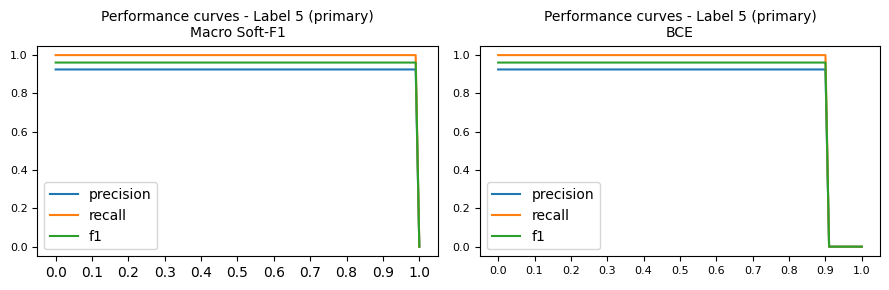

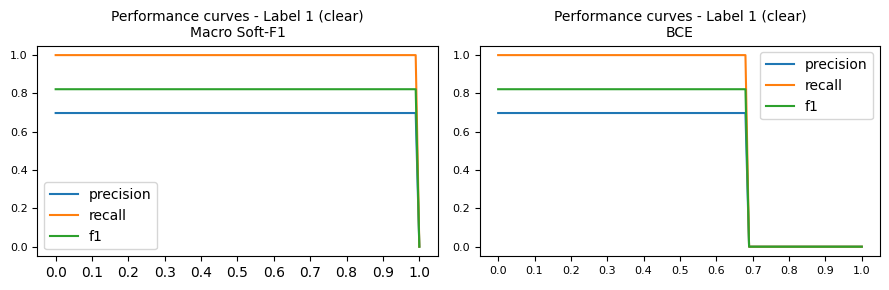

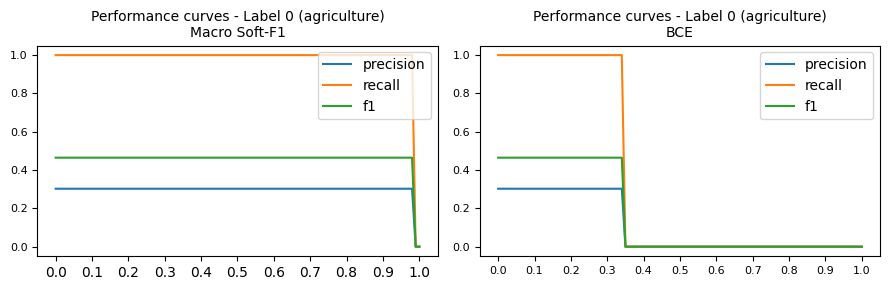

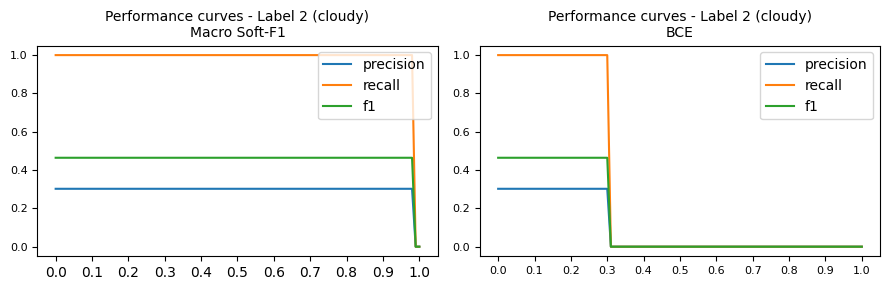

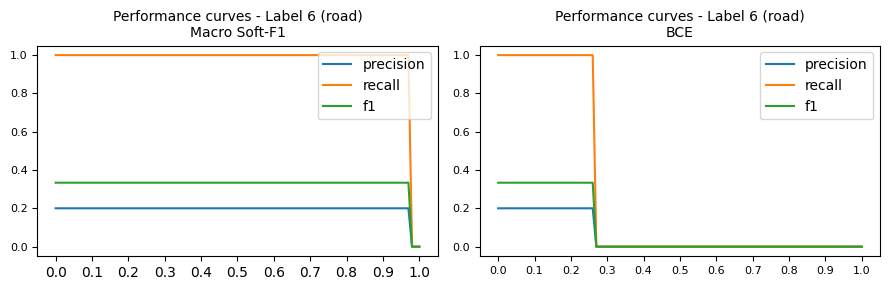

In [37]:
style.use("default")
for l in top5:
    
    label_grid = grid.loc[grid['id']==l, ['precision','recall','f1']]
    label_grid = label_grid.reset_index().drop('index', axis=1)
    
    label_grid_bce = grid_bce.loc[grid_bce['id']==l, ['precision','recall','f1']]
    label_grid_bce = label_grid_bce.reset_index().drop('index', axis=1)
    
    plt.figure(figsize=(9,3))

    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=10)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    label_grid.plot(ax=ax)
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,110,10), labels=np.arange(0,110,10)/100, fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Performance curves - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    label_grid_bce.plot(ax=ax)
    
    plt.tight_layout()
    plt.show()

In [38]:
# Predict on the validation set with both models
y_hat_val = model.predict(val_ds)
y_hat_val_bce = model_bce.predict(val_ds)

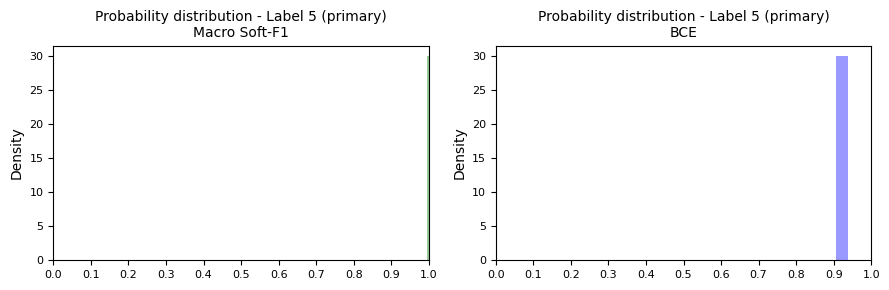

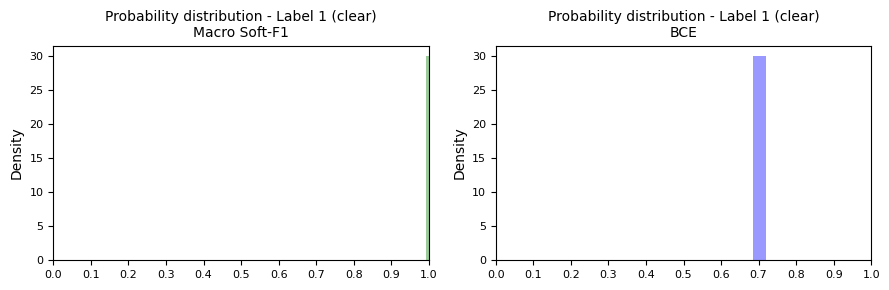

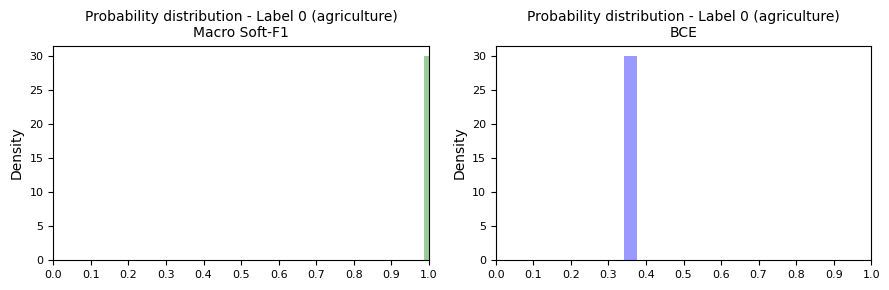

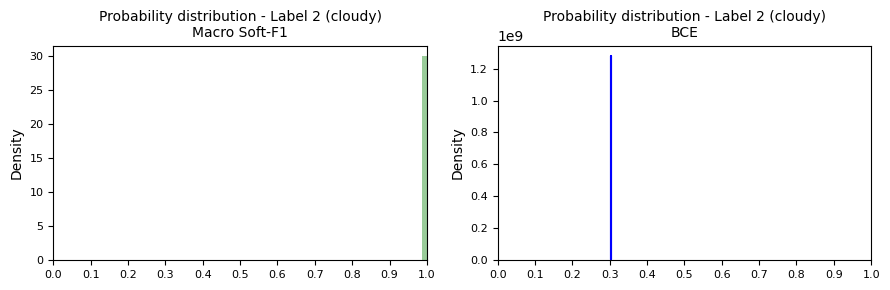

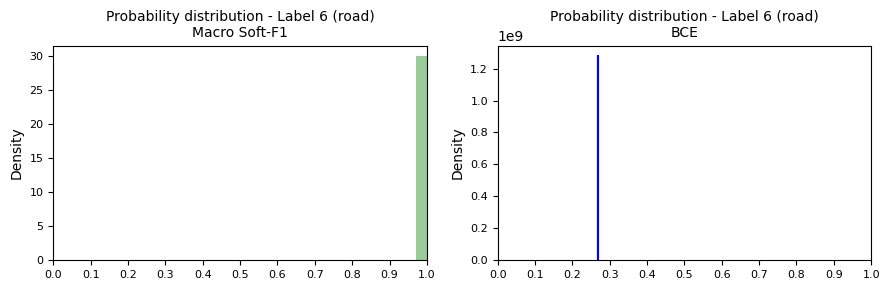

In [39]:
style.use("default")
for l in top5:
        
    plt.figure(figsize=(9,3))
    
    ax = plt.subplot(1, 2, 1)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nMacro Soft-F1', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val[:,l], bins=30, kde=True, color="g")
    
    ax = plt.subplot(1, 2, 2)
    plt.xticks(ticks=np.arange(0,1.1,0.1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.title('Probability distribution - Label '+str(l)+' ('+label_names[l]+')\nBCE', fontsize=10)
    plt.xlim(0,1)
    ax = sns.distplot(y_hat_val_bce[:,l], bins=30, kde=True, color="b")
    
    plt.tight_layout()
    plt.show()

In [40]:
def show_prediction(title, movies_df, model):
    
    # Get movie info
    imdbId = movies.loc[movies['Title']==title]['imdbId'].iloc[0]
    genre = movies.loc[movies['Title']==title]['Genre'].iloc[0]
    img_path = os.path.join('./data/movie_poster/images', str(imdbId)+'.jpg')

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nGenre\n{}\n\nPrediction\n{}\n'.format(title, genre, list(prediction)), fontsize=9)
    plt.show()

In [41]:

#t = datetime.now().strftime("%Y%m%d_%H%M%S")
#export_path = "./models/soft-f1_{}".format(t)
model.save('defo_ks1.h5')
#print("Model with macro soft-f1 was exported in this path: '{}'".format(export_path))

# export_path_bce = "./models/bce_{}".format(t)
# tf.keras.experimental.export_saved_model(model_bce, export_path_bce)
# print("Model with bce was exported in this path: '{}'".format(export_path_bce))